## Data Analysis and Manipulation

In the [previous notebook](./Introduction_NeuralNetworks.ipynb), we learned that given sufficient data, time, and network complexity, neural networks are
capable of approximating continuous functions defined on compact sets to an arbitrary degree. Of course, any neural network we train can only ever be as good
as the data we use to train it; that is, if we hope to train a neural network which generalizes some phenomenon beyond the dataset it was trained on,
we must ensure that the data used to train the network accurately represents the phenomenon we wish to model. In order to determine whether a particular dataset
is well-constructed, we must understand the data set. For this reason, we direct our focus in this notebook toward basic tooling to help transform,
visualize, and analyze various datasets by way of the excellent open-source [pandas](https://pandas.pydata.org/) library. In particular, we will modify the
well-known MNIST database of handwritten digits into a format which is compatible with PyTorch and create a neural network to automatically identify handwritten
digits.

### Software Prerequisites

The following Python libraries are prerequisites to run this notebook; simply run the following code block to install them. They are also listed in the `requirements.txt` file in the root of this notebook's [GitHub repository](https://github.com/uccs-math-clinic/mc-workshops).

In [1]:
%pip install matplotlib==3.5.1 \
             numpy==1.21.5 \
             torch==1.11.0 \
             pandas==1.3.5

You should consider upgrading via the '/work/jonathan/uccs/mc-workshops/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The Python kernel must be restarted after running the above code block for the first time within a particular virtual environment. This may be accomplished by navigating to `Kernel -> Restart` in the menu bar.

With our package dependencies installed, we can run the following [boilerplate code](https://en.wikipedia.org/wiki/Boilerplate_code) in order to import the packages needed for this notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd

%matplotlib notebook
plt.ion()

## The MNIST Handwritten Digit Dataset

The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a collection of digitized handwritten digits which was published by the National Institute
of Standards and Technology in 1998 as a collection of images which was (at the time) ill-suited for machine learning due to the diversity and inconsistency of
handwriting styles which comprise the dataset. For this reason, modeling the MNIST database of handwritten digits with a high degree of accuracy eluded researchers
for quite some time. Modern machine learning techniques (particularly convolutional neural networks) have made this task quite simple, and hence this dataset
serves as an excellent starting point for learning how to model a real-world problem with neural networks.

We begin by examining the original dataset as presented to researchers. We'll first write some code to convert files in this dataset to a _comma-separated values_
(CSV) file, and then we'll load that file into a Numpy array for use in a PyTorch model.

The original dataset contains two sets of files: one for training data, and the other for model validation. Each of these sets contains a file with image _labels_
and a file with the image _data_. Each label is represented by a digit between 0-9, and each image is represented as a list of 784 numbers (corresponding to
a 28x28 pixel image) which take a value between 0-255. This value in turn represents the pixel's grayscale value, with 0 being the darkest and 255 being the
lightest. It is important to note that these files do not contain _images_ - instead, they contain the image's _pixel data_. This means that we can't just use
any old image viewer to see what these digits look like; we'll need to write some code to do to that for us. Along the way, we'll gain a little more understanding
about how the image files with which we are familiar are encoded.

The first file that we'll examine is [t10k-labels.idx1-ubyte](./t10k-labels.idx1-ubyte), which contains image labels for our test set. The first eight bytes of
this file represents some metadata about the file as well as the number of labels that the file contains. Each byte thereafter indicates which number the
corresponding test image represents. For example, the ninth byte (byte `09`) indicates which number the first image represents. The tenth byte contains the
numerical label for the second image, and so on and so forth.

Similarly, the second file [t10k-images.idx3-ubyte](./t10k-images.idx3-ubyte) contains the image test data itself. The first 16 bytes of this file contains file
metadata and indicates the number of images and corresponding image sizes. The next 784 bytes (i.e., bytes `16-800`) represent the pixel values for the first
test image (whose label is indicated by byte `09` from the previous label file) and the 784 bytes after that (i.e., bytes `801 - 1584`) represent the second test
image. In total, there are 10,000 images and corresponding labels encoded into these two files.

More information about these data sets can be found at the [original source](http://yann.lecun.com/exdb/mnist/). In the meantime, let's use our knowledge about
these files to create more array- and matrix-friendly data representations of these images.

In [3]:
# Open files for reading - this lets us read the contents of these files programmatically
# as bytes.
#
test_labels_file = open('./t10k-labels.idx1-ubyte', 'rb')
test_images_file = open('./t10k-images.idx3-ubyte', 'rb')

# Open output CSV file for writing.
#
out_csv_file = open('./mnist_test.csv', 'w')  # This is the file we'll be generating.

# First, let's read past the first 8 bytes of the label file to skip past the file metadata.
#
test_labels_file.read(8)

# We'll do the same thing for the first 16 bytes of the test file metadata.
#
test_images_file.read(16)

# This array will contain our image pixel values. Since we're reading 10,000 images, this
# array will contain 10,000 entries.
#
images = []

# For each of the 10,000 images, we need to read 784 bytes from the images file and one byte
# from the labels file.
#
for i in range(10000):
    # Read i^th image label
    #
    image_label = [ord(test_labels_file.read(1))]

    # Read i^th image pixels
    #
    image_pixels = []
    for j in range(784):
        image_pixels.append(ord(test_images_file.read(1)))

    # Add label and pixels to "images" array. The "+" operator here
    # simply concatenates the "image_label" and "image_pixels" arrays
    # together.
    #
    images.append(image_label + image_pixels)

# Let's print the first array value just to see what we have at this point as a
# sanity check.
#
print('First image label: {}'.format(images[0][0]))
print('First image pixel values:')
[print(images[0][k*28+1:k*28+28]) for k in range(round((len(images[0]) - 1)/28))]

# We'll add column headers to the CSV file here.
#
out_csv_file.write('label,')
out_csv_file.write(','.join('pixel_{}'.format(i) for i in range(784)) + '\n')

# Now, let's comma-separate each image array value.
#
for image_data in images:
    out_csv_file.write(
        ','.join(str(image_datum) for image_datum in image_data) + '\n'
    )

# Close files
#
test_images_file.close()
test_labels_file.close()

out_csv_file.close()

First image label: 7
First image pixel values:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 84, 185, 159, 151, 60, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 222, 254, 254, 254, 254, 241, 198, 198, 198, 198, 198, 198, 198, 198, 170, 52, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 67, 114, 72, 114, 163, 227, 254, 225, 254, 254, 254, 250, 229, 254, 254, 140, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 66, 14, 67, 67, 67, 59, 2

## Interlude - Visualizing Our Data

Now that we have our MNIST data as a nicely-formatted CSV, we can use some of the more popular Python libraries to dig into our data to begin to get
a feel for its structure. The library we have in mind is [pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html),
which provides a wide variety of useful data exploration capabilities. We'll begin by loading our generated CSV file into a
[pandas.DataFrame](https://pandas.pydata.org/docs/reference/frame.html) instance. The `pandas` library provides a convenient `read_csv` function just for
this purpose.

In [4]:
mnist_df = pd.read_csv('./mnist_test.csv')

mnist_df.head()  # This function prints the first 10 rows of our data frame.

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Restricting Columns

We might not always want to see every column in a particular CSV file. Fortunately, `pandas` provides an easy way to only view a particular column:

In [5]:
mnist_df['label']  # Only print the column labeled "label"

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: label, Length: 10000, dtype: int64

### Label Counts

We can then calculate counts of each digit number using the `value_counts` function:

In [6]:
mnist_df['label'].value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

### Normalized Label Distribution

This gives us the raw numbers sorted by decreasing frequency. Let's look as the relative frequency of each digit by normalizing the data
and sorting by index.

In [7]:
mnist_df['label'].value_counts(normalize=True).sort_index()

0    0.0980
1    0.1135
2    0.1032
3    0.1010
4    0.0982
5    0.0892
6    0.0958
7    0.1028
8    0.0974
9    0.1009
Name: label, dtype: float64

## Pixel Distribution

We can also use DataFrames to take a look at our actual image data. For instance, to see which pixel value(s) show up the most often in our data set, we can drop the first column (since we don't need the labels), stack our data vertically as one giant column, and then sort by index.

In [12]:
mnist_df.drop('label', axis=1).stack().value_counts(normalize=True).sort_index()

0      0.807242
1      0.000489
2      0.000734
3      0.000778
4      0.000813
         ...   
251    0.001734
252    0.015129
253    0.033397
254    0.017375
255    0.007249
Length: 256, dtype: float64

These few capabilities comprise only a very small subset of the full set of analytics capabilities that Data Frames provide. The full documentation for this
powerful tool can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), and the interested reader is highly encouraged to
experiment with some other DataFrame methods on our MNIST data set. For now, however, we'll complete our brief survey of data analytics by actually plotting
an image!

### Plotting an Image

Recall that our data in its current form is structured as a list of rows which contain the image label which is proceeded by 784 values which indicate the
grayscale shade of a particular pixel. Thus, in order to visualize a particular image in a more familiar way, we need to convert our image from a row of pixel
values into a 28x28 pixel grid. Fortunately, `pandas` utilizes the `numpy` library under the hood, which means that we can take advantage of that fact to easily
reshape our data.

<IPython.core.display.Javascript object>


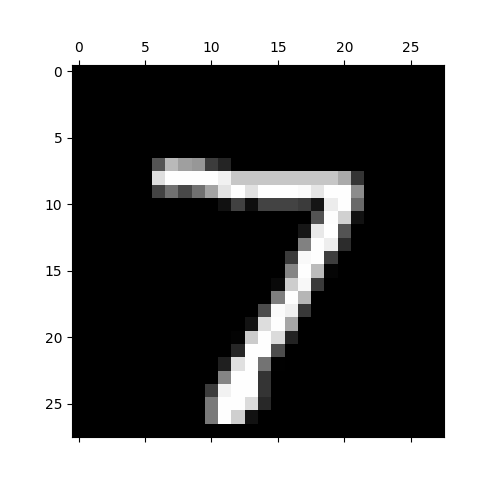

In [9]:
# iloc[0] selects the first image (index 0) from our DataFrame. Feel free to
# replace "0" with any other number between 0-9999 to view a different image.
#
image_row_vector = mnist_df.drop('label', axis=1).iloc[0].values

# We use numpy's .reshape method to turn our row vector into a 28x28 matrix.
#
image_matrix = image_row_vector.reshape(28, 28)

# Now we plot our pixel matrix as a grayscale image
#
fig = plt.matshow(image_matrix, cmap=plt.cm.gray)

## Loading Data into PyTorch

At this point, we are ready to load data into PyTorch in order to train a neural network to classify all these digits.

In [10]:
# dl_train_set = datasets.MNIST('./data', train=True, download=True)
# dl_test_set = datasets.MNIST('./data', train=False, download=True)

# train_set_array = train_set.data.numpy()
# test_set_array = test_set.data.numpy()